# Task 2 Ptbdb Data (LSTM-FCN,Encoder)

## Loading modules
Note we load models, data and plotting function from models.ipynb and helper_functions.ipynb

In [1]:
import itertools

In [2]:
import io
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import tensorflow as tf
import tensorflow_addons as tfa
from inspect import signature
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
%load_ext tensorboard
# For evaluation

## Load needed functions

### Models

In [4]:
# https://github.com/houshd/LSTM-FCN
# With adjsuted hyperaprameters
def LSTM_FCN(nclass, time_steps, features, af):

    inputs = keras.layers.Input([time_steps, features])

    x = keras.layers.Masking()(inputs)
    x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dropout(0.8)(x)

    y = keras.layers.Permute((2, 1))(inputs)
    y = keras.layers.Conv1D(64, 8, padding='same',
                            kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Activation('relu')(y)

    y = keras.layers.Conv1D(128, 5, padding='same',
                            kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Activation('relu')(y)

    y = keras.layers.Conv1D(256, 3, padding='same',
                            kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Activation('relu')(y)

    y = keras.layers.GlobalAveragePooling1D()(y)

    x = keras.layers.concatenate([x, y])

    out = keras.layers.Dense(nclass, activation=af)(x)
    model = keras.Model(inputs, out)
    model.summary()
    return model


# https://www.cinc.org/archives/2020/pdf/CinC2020-227.pdf tried out different hyperparameters, but the one provided gave best results
def Encoder(nclass, time_steps, features, af):
    input_layer = keras.layers.Input(shape=(time_steps, features))

    # conv block -1
    conv1 = keras.layers.Conv1D(
        filters=160, kernel_size=5, strides=1, padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(
        filters=224, kernel_size=9, strides=1, padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(
        filters=256, kernel_size=9, strides=1, padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:, :, :128])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:, :, 128:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()(
        [attention_softmax, attention_data])
    # last layer
    dense_layer = keras.layers.Dense(
        units=2048, activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(
        units=nclass, activation=af)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

### Helper functions

In [5]:
def get_model(data, model_name):
    time_steps = 187
    features = 1
    if data == "mitbih":
        number_class = 5
        activation_function = "softmax"
        loss = losses.sparse_categorical_crossentropy
    elif data == "ptbdb":
        number_class = 1
        activation_function = "sigmoid"
        loss = losses.binary_crossentropy
    if model_name == "ResNet":
        np.expand_dims(X_train, -1)
        np.expand_dims(Y_train, -1)
        model = ResNet(number_class, time_steps, features, activation_function)
    elif model_name == "CNN":
        model = CNN(number_class, time_steps, features, activation_function)
    elif model_name == "CNNDML":
        model = CNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "RNN":
        model = RNN(number_class, time_steps, features, activation_function)
    elif model_name == "RNNDML":
        model = RNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "BaseLine":
        model = BaseLine(number_class, time_steps,
                         features, activation_function)

    elif model_name == "Transformer":
        model = Transformer(number_class, time_steps,
                            features, activation_function)
    elif model_name == "LSTM_FCN":
        model = LSTM_FCN(number_class, time_steps,
                         features, activation_function)
    elif model_name == "Encoder":
        model = Encoder(number_class, time_steps,
                        features, activation_function)
    elif model_name == "EncoderDML":
        model = EncoderDML(number_class, time_steps,
                           features, activation_function)
    elif model_name == "RNNAdvanced":
        model = RNNAdvanced(number_class, time_steps,
                            features, activation_function)
    elif model_name == "CNN2":
        model = CNN2(number_class, time_steps, features, activation_function)
    return model, loss


def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(X_test)
    test_pred = (test_pred > 0.5).astype(np.int8)
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = False
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


def log_auroc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    fpr, tpr, thresholds = roc_curve(Y_test, pred_test)
    figure = plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.3f)" % (roc_auc_score(Y_test, pred_test)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model_name+"-AUROC")
    plt.legend(loc="lower right")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUROC", image, step=epoch)


def log_auprc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    average_precision = average_precision_score(Y_test, pred_test)
    precision, recall, _ = precision_recall_curve(Y_test, pred_test)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    figure = plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(model_name+"-AUPRC: AP={0:0.3f}".format(average_precision))

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUPRC", image, step=epoch)


def plot_roc(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.2f)" % (roc_auc_score(y_actual, y_pred)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


def plot_precisionrecall(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    average_precision = average_precision_score(y_actual, y_pred)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall curve: AP={0:0.2f}".format(average_precision))


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def get_transfer_model(model):
    model.trainable = False
    model_input = model.inputs
    model_output = model.layers[-4].output

    X = keras.layers.Dense(32, activation='relu')(model_output)
    X = keras.layers.Dense(32, activation='relu')(X)
    out = keras.layers.Dense(1, activation='sigmoid')(X)

    transfer_model = keras.Model(inputs=model_input, outputs=out)
    return transfer_model


def plot_model_results(model, history, model_path, data, model_name, X_test, Y_test):
    model.load_weights(model_path)
    if model_name == "ResNet":
        X_test = np.expand_dims(X_test, -1)
        Y_test = np.expand_dims(Y_test, -1)
        model.evaluate(X_test, Y_test)
    if data == "mitbih":
        mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        pred_test = model.predict(X_test)
        pred_test = np.argmax(pred_test, axis=-1)

        pd.DataFrame(history.history).plot(figsize=(8, 5))

        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)

        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))

        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*mitbih_dict],
            normalize=True,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
    elif data == "ptbdb":
        ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
        pred_test = model.predict(X_test)
        pred_test = (pred_test > 0.5).astype(np.int8)
        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)
        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))
        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*ptbdb_dict],
            normalize=False,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
        plot_roc(Y_test, pred_test)
        plot_precisionrecall(Y_test, pred_test)

#### Define path, where data is stored and where you want the models and results stored!

In [6]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models/01-Ptbdb/02-Task2")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/01-Ptbdb/02-Task2")

## LSTM-FCN
### Compile and run

In [7]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "ptbdb"
model_name = "LSTM_FCN"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
classes = [*ptbdb_dict]

# Define Hyperparameters
epochs = 40
learning_rate = 0.005
batch_size = 512
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_accuracy", mode="max", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

# Also we add plot callbacks to get pretty evolution of intresting plots over each epochs
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
auroc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auroc)
auprc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auprc)

callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
    auroc_callback,
    auprc_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 1, 187)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 1, 64)        95808       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 64)       256         ['conv1d[0][0]']                 
 alization)                                                                                   

In [8]:
# Compile and Run
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8327 - auc: 0.8997 - prc: 0.9585
Epoch 1: val_accuracy improved from -inf to 0.80172, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\LSTM_FCN_ptbdb_weights.h5
21/21 [==============================] - 12s 361ms/step - loss: 0.3518 - accuracy: 0.8327 - auc: 0.8997 - prc: 0.9585 - val_loss: 0.4338 - val_accuracy: 0.8017 - val_auc: 0.8817 - val_prc: 0.9501 - lr: 0.0050
Epoch 2/40
20/21 [===========================>..] - ETA: 0s - loss: 0.1883 - accuracy: 0.9260 - auc: 0.9725 - prc: 0.9885
Epoch 2: val_accuracy did not improve from 0.80172
21/21 [==============================] - 5s 228ms/step - loss: 0.1878 - accuracy: 0.9262 - auc: 0.9726 - prc: 0.9886 - val_loss: 0.4364 - val_accuracy: 0.7803 - val_auc: 0.8645 - val_prc: 0.9416 - lr: 0.0050
Epoch 3/40
20/21 [===========================>..] - ETA: 0s - loss: 0.1355 - accuracy: 0.

Epoch 19/40
20/21 [===========================>..] - ETA: 0s - loss: 0.0193 - accuracy: 0.9929 - auc: 0.9994 - prc: 0.9996
Epoch 19: val_accuracy did not improve from 0.95622
21/21 [==============================] - 5s 245ms/step - loss: 0.0199 - accuracy: 0.9927 - auc: 0.9993 - prc: 0.9996 - val_loss: 0.1896 - val_accuracy: 0.9502 - val_auc: 0.9767 - val_prc: 0.9827 - lr: 0.0050
Epoch 20/40
21/21 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9934 - auc: 0.9996 - prc: 0.9998
Epoch 20: val_accuracy improved from 0.95622 to 0.95794, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\LSTM_FCN_ptbdb_weights.h5
21/21 [==============================] - 5s 233ms/step - loss: 0.0186 - accuracy: 0.9934 - auc: 0.9996 - prc: 0.9998 - val_loss: 0.1484 - val_accuracy: 0.9579 - val_auc: 0.9820 - val_prc: 0.9889 - lr: 0.0050
Epoch 21/40
20/21 [===========================>..] - ETA: 0s - loss: 0.0131 - accur

Epoch 36: early stopping


### Results LSTM-FCN

Test F1 score : 0.9723
Test ACC score : 0.9777
Confusion matrix, without normalization
[[ 782   27]
 [  38 2064]]


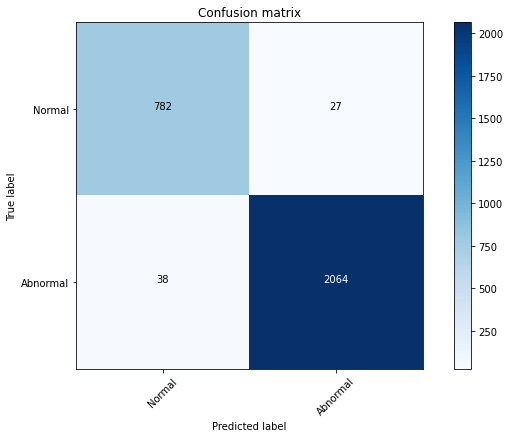

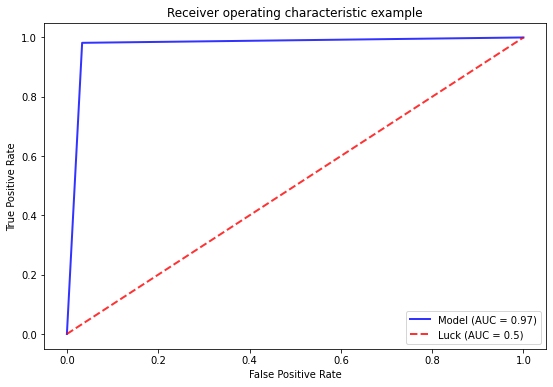

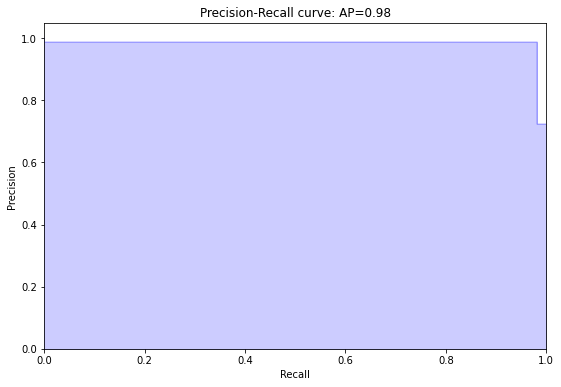

In [9]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [10]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\LSTM_FCN_ptbdb\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\LSTM_FCN_ptbdb\assets


## Encoder
### Compile and run

In [23]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "ptbdb"
model_name = "Encoder"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
classes = [*ptbdb_dict]

# Define Hyperparameters
epochs = 40
learning_rate = 0.00005
batch_size = 32
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss",
                      mode="min", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_loss", mode="min", patience=3, verbose=2, factor=0.085)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

# Also we add plot callbacks to get pretty evolution of intresting plots over each epochs
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
auroc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auroc)
auprc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auprc)

callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
    auroc_callback,
    auprc_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

In [24]:
# Compile and Run
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
328/328 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8391 - auc: 0.8917 - prc: 0.9530
Epoch 1: val_loss improved from inf to 0.24754, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\Encoder_ptbdb_weights.h5
328/328 [==============================] - 11s 27ms/step - loss: 0.3644 - accuracy: 0.8391 - auc: 0.8917 - prc: 0.9530 - val_loss: 0.2475 - val_accuracy: 0.9116 - val_auc: 0.9602 - val_prc: 0.9820 - lr: 5.0000e-05
Epoch 2/40
325/328 [============================>.] - ETA: 0s - loss: 0.2284 - accuracy: 0.9062 - auc: 0.9601 - prc: 0.9840
Epoch 2: val_loss improved from 0.24754 to 0.16575, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\Encoder_ptbdb_weights.h5
328/328 [==============================] - 8s 25ms/step - loss: 0.2276 - accuracy: 0.9065 - auc: 0.9605 - prc: 0.9842 - val_loss: 0.1657 - val_accur

Epoch 18/40
328/328 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9895 - auc: 0.9991 - prc: 0.9996
Epoch 18: val_loss did not improve from 0.02401
328/328 [==============================] - 8s 25ms/step - loss: 0.0299 - accuracy: 0.9895 - auc: 0.9991 - prc: 0.9996 - val_loss: 0.0332 - val_accuracy: 0.9888 - val_auc: 0.9996 - val_prc: 0.9998 - lr: 5.0000e-05
Epoch 19/40
327/328 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9897 - auc: 0.9993 - prc: 0.9997
Epoch 19: val_loss did not improve from 0.02401

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.24999989263597e-06.
328/328 [==============================] - 8s 25ms/step - loss: 0.0292 - accuracy: 0.9897 - auc: 0.9993 - prc: 0.9997 - val_loss: 0.0256 - val_accuracy: 0.9914 - val_auc: 0.9996 - val_prc: 0.9998 - lr: 5.0000e-05
Epoch 20/40
326/328 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9919 - auc: 0.9996 - prc: 0.9999
Epoch 20: val_loss improve

### Results Encoder

Test F1 score : 0.9923
Test ACC score : 0.9938
Confusion matrix, without normalization
[[ 797   12]
 [   6 2096]]


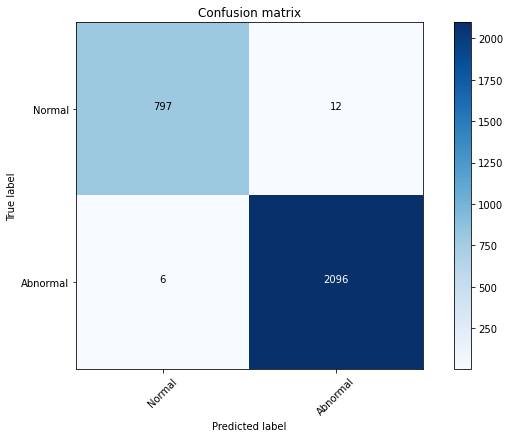

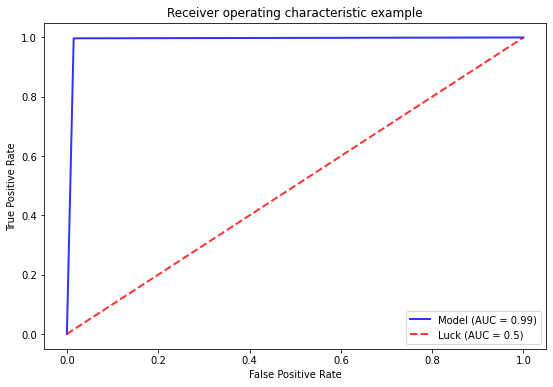

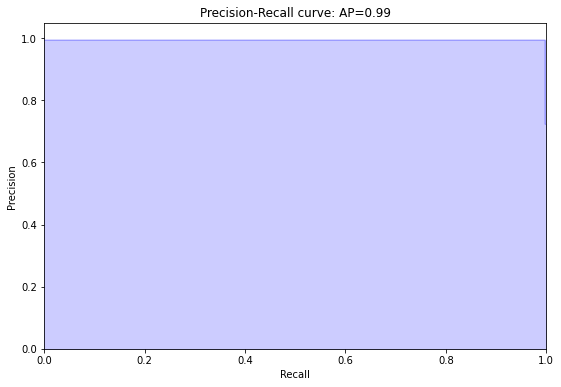

In [25]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [14]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\Encoder_ptbdb\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models/01-Ptbdb/02-Task2\Encoder_ptbdb\assets


In [15]:
## Visualizaitons in tensorboard

In [16]:
# Please have a look at in Tensorboard with all needed figures,
# change mode to light on half-moon icon to see labels and move circle above cm to see evolution for each epoch
# You can also look at the results in your browser, see tensorboard documentation
# AUPRC and AUROC in section "Scalars" are calc. with validation set, images are calcualted with test set.

# At parent path, so both Results are compared to each other
%tensorboard --logdir {tensorboard_path_parent.replace(os.sep, '/')}
# Or go into your console and type: tensorboard --logdir='...\Submission\04-Logs\01-Ptbdb'

Reusing TensorBoard on port 6006 (pid 2200), started 0:53:34 ago. (Use '!kill 2200' to kill it.)

## Results